In [65]:
import pandas as pd
df = pd.read_parquet("../others/price_top290.parquet")
stock_list = set(df['ticker_market'])

In [66]:
import yfinance as yf
import statsmodels.api as sm
import warnings
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import pacf
warnings.filterwarnings("ignore")
resample_map = {
    "weekly": "W",
    "biweekly": "2W",
    "monthly": "M"
}

# params
train_end_str = "2019-01-01"
train_end = pd.to_datetime(train_end_str)
train_start = train_end - timedelta(days=365)

df = yf.download(stock_list, start=train_start, end="2024-01-01", progress=False)
close = df['Adj Close']
pct_change = close.pct_change().dropna()
pct_change = pct_change.resample(resample_map['monthly']).sum()


15 Failed downloads:
['6949.TW', '00945B.TW', '6423.TW', '6906.TW', '8487.TW', '00942B.TWO', '6928.TW', '00941.TW', '6771.TW', '00939.TW', '1563.TW', '00657K.TW', '2762.TW']: YFChartError("%ticker%: Data doesn't exist for startDate = 1546272000, endDate = 1704038400")
['020013.TWO']: YFInvalidPeriodError("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")
['00729R.TW']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2019-01-01 00:00:00 -> 2024-01-01)')


$00729R.TW: possibly delisted; No price data found  (1d 2019-01-01 00:00:00 -> 2024-01-01)


In [ ]:
modeling_end = "2020-01-01"
starter_index = np.where(pct_change.index < pd.to_datetime(modeling_end))[0][-1]
factors = []
indices = []
for index in range(len(pct_change)-starter_index+1):

    # rolling calculating time series
    pct_change_train = pct_change.iloc[index:starter_index+index]
    print(pct_change_train.index[0], pct_change_train.index[-1])
    prediction_factor = []
    for ticker in list(pct_change_train.columns):
        # get max lags with pacf
        pacf_values = pacf(pct_change_train[ticker], method='ywm')
        
        N = len(pct_change_train[ticker])
        threshold = 1.96 / np.sqrt(N)

        significant_indices = np.where(np.abs(pacf_values) > threshold)[0]
        significant_pacf_values = pacf_values[significant_indices]
        if len(significant_indices) >= 2:
            best_lag_n = significant_indices[1]
        elif len(significant_indices) == 1:
            best_lag_n = np.argmax(np.abs(pacf_values[1:])) + 1

        # get predictions(upward/downward)
        train_data = pct_change_train[ticker]
        model = sm.tsa.arima.ARIMA(train_data, order=(best_lag_n, 0, 0)) # order = (ar_t, i_t, ma_t), for ar model only => ma_t = 0
        model_fit = model.fit()
        prediction = model_fit.forecast()
        # print(ticker, prediction[0], prediction.index[0])
        prediction_factor.append(prediction[0])
    factors.append(prediction_factor)
    indices.append(pct_change_train.index[-1])

<Axes: >

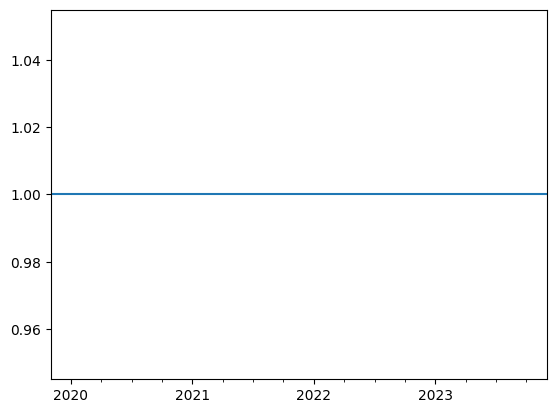

In [161]:
tester = pd.DataFrame(factors, columns=list(pct_change_train.columns), index=indices)
df1 = tester.dropna(axis='columns', how='all').copy()
demean = df1.sub(df1.mean(axis=1), axis=0)
weighting = demean.div(demean.abs().sum(axis=1), axis=0)
def normalize_weights(df):
    long_weights = df[df > 0]
    
    normalized_long_weights = long_weights.div(long_weights.sum(axis=1), axis=0).fillna(0)
    
    return normalized_long_weights

normalized_long_weights = normalize_weights(weighting)
# check weighting allocation for each time period
normalized_long_weights.sum(axis=1).plot()

In [162]:
close_prices_df = pd.DataFrame(df['Adj Close'])
close_prices_df.dropna(how='any', axis=1, inplace=True)
close_prices_df_m = close_prices_df.resample('M').mean()
close_prices_df_m.head()

Ticker,0050.TW,0053.TW,0056.TW,006201.TWO,006203.TW,006204.TW,006205.TW,006208.TW,00625K.TW,00633L.TW,...,9931.TW,9933.TW,9934.TW,9935.TW,9937.TW,9939.TW,9940.TW,9943.TW,9944.TW,9951.TWO
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-31,62.623558,26.480255,16.840946,9.353506,29.047661,40.247168,26.265714,36.048015,5.820476,30.470952,...,23.701007,36.094828,14.299263,16.681607,32.798251,37.923218,23.430936,54.010322,14.438030,69.545767
2019-02-28,65.266069,28.083000,17.806573,10.185446,30.408654,41.990323,29.026154,37.484955,6.389231,36.930000,...,24.276625,37.107182,14.426957,20.449069,32.860587,39.449872,24.425731,57.574765,14.430040,71.120520
2019-03-31,66.562499,28.861326,18.137935,10.335494,30.978391,42.925966,31.384000,38.349341,6.873000,41.370000,...,24.295179,37.595288,14.528047,22.456285,32.946563,38.896064,23.766056,56.433042,14.407611,71.954443
2019-04-30,70.154111,30.848613,18.849520,11.031378,32.769381,44.855900,33.212500,40.350638,7.267000,47.297000,...,24.252172,36.711513,15.080041,20.145395,34.417952,38.490897,24.239069,57.328167,14.249578,71.088433
2019-05-31,68.135118,29.225917,18.176832,10.404985,31.746649,43.643057,30.386818,39.112902,6.727273,41.425909,...,24.301470,36.203730,14.859436,20.988636,34.607388,38.590064,24.619088,58.185622,14.232986,65.355349


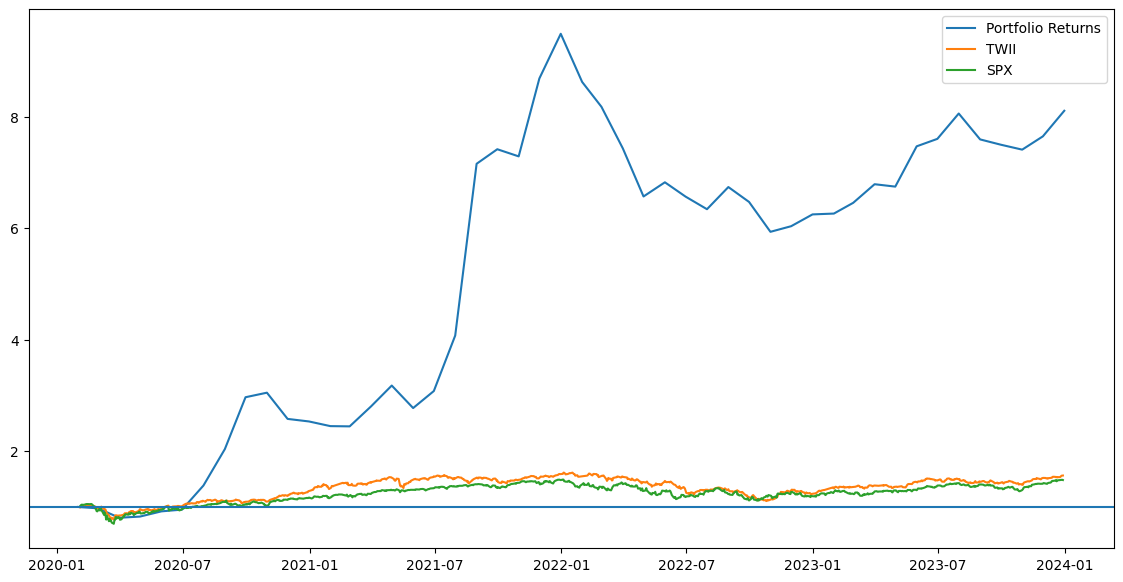

Sharpe Ratio: 1.1834035052924927
CAGR: 68.74%
Karma Ratio: 2.3547384037134647


In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
fee = 0.01
portfolio_returns = (normalized_long_weights * close_prices_df_m.pct_change()).sum(axis=1)
portfolio_returns = portfolio_returns[portfolio_returns.index >= modeling_end]
# Plot returns
plt.figure(figsize=(14, 7))
returns_series = (1 + portfolio_returns).cumprod()*(1-fee)
spx = yf.download("^GSPC", start=returns_series.index[0], end=returns_series.index[-1], progress=False)['Adj Close']
twii = yf.download("^TWII", start=returns_series.index[0], end=returns_series.index[-1], progress=False)['Adj Close']

plt.plot(returns_series, label='Portfolio Returns')

benchmark = pct_change[pct_change.index >= portfolio_returns.index[0]]

plt.plot((1 + twii.pct_change()).cumprod(), label='TWII')
plt.plot((1 + spx.pct_change()).cumprod(), label='SPX')
plt.axhline(1)
plt.legend()
plt.show()

# Calculate performance metrics
def sharpe_ratio(returns, risk_free_rate=0.03):
    excess_return = ((1 + returns).cumprod()*(1-fee)) - risk_free_rate
    return  (np.mean(excess_return)/ np.std(excess_return))**(1/4)
def karma_ratio(returns):
    positive_returns = returns[returns > 0]
    negative_returns = returns[returns < 0]

    if len(negative_returns) == 0:
        karma_ratio = np.mean(positive_returns) / 0.00001  # Avoid division by zero
    else:
        karma_ratio = np.mean(positive_returns) / np.abs(np.mean(negative_returns))

    return karma_ratio

print("Sharpe Ratio:", sharpe_ratio(portfolio_returns))
print(f"CAGR: {np.round(((returns_series[-1])**(1/4)-1)*100, 2)}%")
print("Karma Ratio:", karma_ratio(portfolio_returns))



Maximum Drawdown (MDD): -37.46%


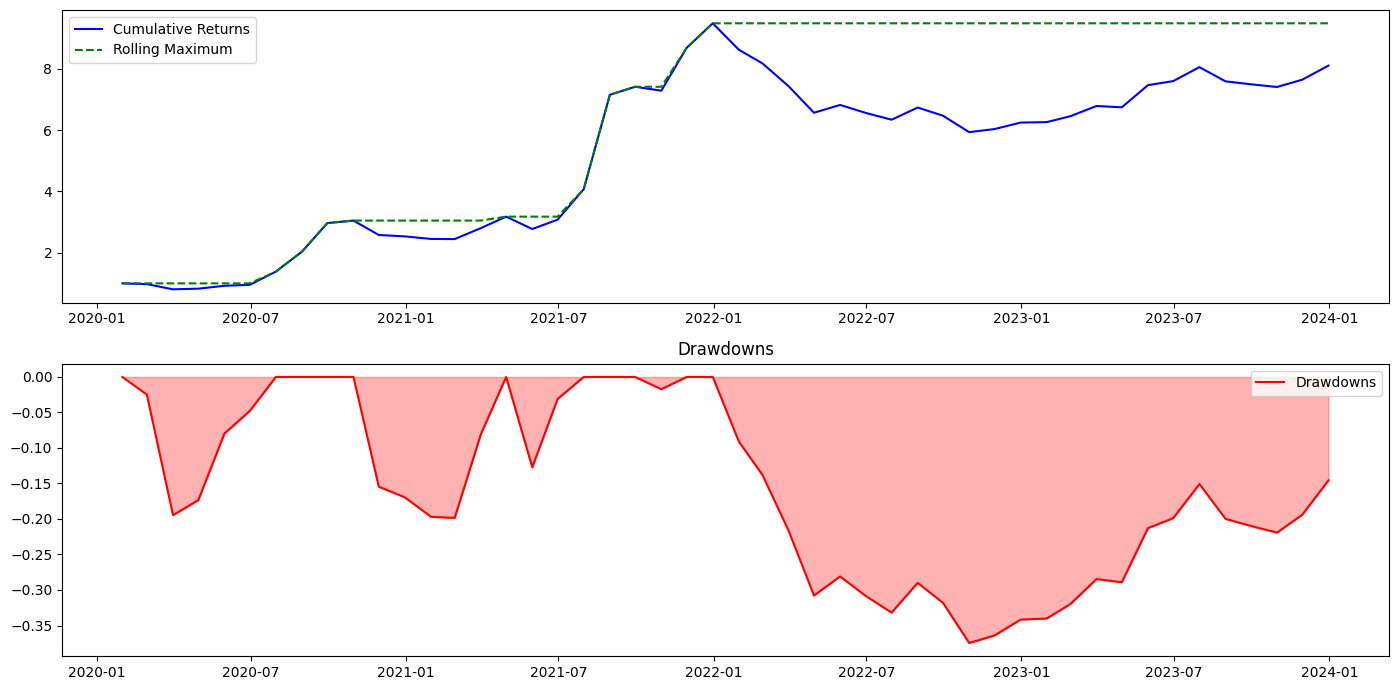

In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


cumulative_returns = returns_series

rolling_max = cumulative_returns.cummax()

drawdowns = (cumulative_returns - rolling_max) / rolling_max

max_drawdown = drawdowns.min()

# Print the Maximum Drawdown
print("Maximum Drawdown (MDD): {:.2%}".format(max_drawdown))

plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plt.plot(cumulative_returns, label='Cumulative Returns', color='blue')
plt.plot(rolling_max, label='Rolling Maximum', color='green', linestyle='--')
plt.legend()

# Plot drawdowns
plt.subplot(2, 1, 2)
plt.plot(drawdowns, label='Drawdowns', color='red')
plt.fill_between(drawdowns.index, drawdowns, color='red', alpha=0.3)
plt.title('Drawdowns')
plt.legend()

plt.tight_layout()
plt.show()


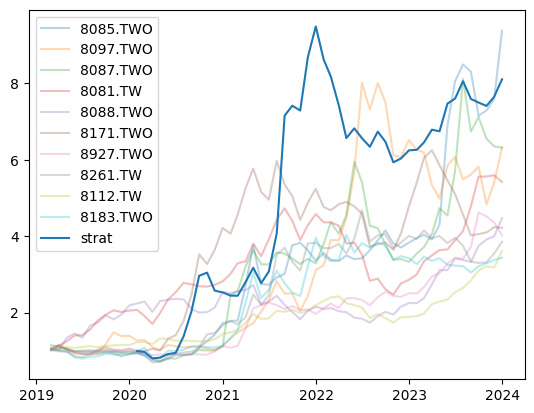

In [202]:
# plotting greatest 10 stocks(w/o outlier 8227.TWO) vs. strategy
top = 10
close_t = close.T
close_t["total_return"] = (close_t.iloc[:, -1] - close_t.iloc[:, 0])/close_t.iloc[:, 0]
close_order_by_total_return = close_t.sort_values(by='total_return', ascending=False).iloc[1:top+1, :-1].T # 8227: outlier
close_order_by_total_return.index = pd.to_datetime(close_order_by_total_return.index)
top10_resample_m = close_order_by_total_return.resample("M").mean()
close_order_by_total_return_cumprod = (1+top10_resample_m.pct_change()).cumprod()
plt.plot(close_order_by_total_return_cumprod, label=close_order_by_total_return_cumprod.columns, alpha=0.3)
plt.plot(returns_series, label='strat')
plt.legend()


In [188]:
for index, row in normalized_long_weights.iterrows():
    holdings = row[row > 0].index
    if "8227.TWO" in holdings:
        print(row.name)

2020-03-31 00:00:00
2020-04-30 00:00:00
2020-05-31 00:00:00
2020-06-30 00:00:00
2020-07-31 00:00:00
2020-10-31 00:00:00
2021-07-31 00:00:00
2021-08-31 00:00:00
2021-09-30 00:00:00
2021-10-31 00:00:00
2021-11-30 00:00:00
2021-12-31 00:00:00
2022-01-31 00:00:00
2022-02-28 00:00:00
2022-03-31 00:00:00
2022-04-30 00:00:00
2022-05-31 00:00:00
2022-06-30 00:00:00
2022-07-31 00:00:00
2022-10-31 00:00:00
2022-12-31 00:00:00
2023-01-31 00:00:00
2023-03-31 00:00:00
2023-04-30 00:00:00
2023-05-31 00:00:00
2023-06-30 00:00:00
2023-07-31 00:00:00
2023-08-31 00:00:00
2023-09-30 00:00:00
2023-10-31 00:00:00
2023-11-30 00:00:00
2023-12-31 00:00:00
